In [1]:
from utils import *

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

import logomaker

In [2]:
def make_plot(
    mAb_ds,
    loc_start,
    loc_end,
    textlabel,
    outname_prefix
):
    # line colors for each replicate
    oi_blue       = '#0072B2'
    oi_vermillion = '#D55E00'

    # colors for logo categories
    col_acidic  = '#FF0000'
    col_basic   = '#0000FF'
    col_hydroph = '#000000'
    col_neutral = '#800080'
    col_polar   = '#008000'
    
    #
    # Make dataframe of scaled differential selection values for sites in the
    # range of interest, with each row corresponding to a site position and
    # each column corresponding to the amino acid mutant
    #
    epitope_pids = id_query(mAb_ds,f'{loc_start} <= Loc <= {loc_end}','peptide')
    epitope_ds = mAb_ds.loc[dict(peptide_id=epitope_pids)]

    row_indices = np.arange(loc_start, loc_end+1)
    col_indices = sorted(list(set(epitope_ds.peptide_table.loc[:,'aa_sub'].values.tolist())))

    epitope_df = pd.DataFrame(0., index=row_indices, columns=col_indices)

    for ploc in row_indices:
        for paa in col_indices:
            loc_aa_pid = id_query(epitope_ds,f'(Loc=={ploc}) & (aa_sub=="{paa}")','peptide')
            loc_aa_diff_sel = np.mean(epitope_ds.loc[dict(peptide_id=loc_aa_pid)].diff_sel.values[0])
            val = np.mean(epitope_ds.loc[dict(peptide_id=loc_aa_pid)]["smooth_flank_1_scaled_diff_sel"].values[0])
            epitope_df.at[ploc, paa] = val

    #
    # Get enrichment values of the wildtype peptides for each sample replicate
    #
    wt_pids = id_query(epitope_ds,'is_wt==True','peptide')
    wt_ds = epitope_ds.loc[dict(peptide_id=wt_pids)]
    sids = wt_ds.sample_id.to_numpy()
    enr0 = wt_ds.loc[dict(sample_id=sids[0])].enrichment.values
    enr1 = wt_ds.loc[dict(sample_id=sids[1])].enrichment.values

    region_loc_wt_aa = wt_ds.peptide_table.loc[:,'aa_sub'].values.tolist()

    #
    # Plotting
    #
    fig = plt.figure(figsize=[15,15])
    fig.set_facecolor('white')
    gs = fig.add_gridspec(2, hspace=0, height_ratios=(1,3))
    axs = gs.subplots(sharex=False, sharey=False)

    # enrichment line plots
    axs[0].plot(range(loc_start, loc_end+1), enr0, color=oi_blue)
    axs[0].plot(range(loc_start, loc_end+1), enr1, color=oi_vermillion)
    plt.setp(axs[0].get_yticklabels(), fontsize=20)
    axs[0].set_ylabel('enrichment', fontsize=28, labelpad=10)
    axs[0].grid(linestyle='--')
    axupper = axs[0].secondary_xaxis('top')
    plt.setp(axupper.get_xticklabels(), fontsize=20)
    axupper.set_xlabel("peptide location", fontsize=28, labelpad=10)

    # scaled differential selection logo plot
    logomaker.Logo(epitope_df,
                   ax=axs[1],
                   vpad=0.05,
                   color_scheme='chemistry',
                   show_spines=True,
                   flip_below=False,
                   zorder=2
                  )
    axs[1].set_xlabel("wildtype amino acid", fontsize=28, labelpad=10)
    axs[1].set_ylabel('scaled differential selection', fontsize=28, labelpad=10)
    axs[1].label_outer()
    axs[1].set_xticks(np.arange(loc_start, loc_end+1))
    axs[1].set_xticklabels(region_loc_wt_aa)
    plt.setp(axs[1].get_xticklabels(), fontsize=24)
    plt.setp(axs[1].get_yticklabels(), fontsize=20)
    axs[1].grid(axis='x',linestyle='--')

    axs[0].set_xlim(axs[1].get_xlim())

    mAb_font = {'fontname':'DejaVu Serif'}
    axs[0].text(0.1,0.85,textlabel,
                fontsize=30,
                horizontalalignment='center',
                verticalalignment='center',
                transform=axs[0].transAxes,
                **mAb_font
               )

    # legend
    acidic_handle  = Line2D([0], [0], marker='s', color='w', markerfacecolor=col_acidic,  markersize=20, label='acidic')
    basic_handle   = Line2D([0], [0], marker='s', color='w', markerfacecolor=col_basic,   markersize=20, label='basic')
    hydroph_handle = Line2D([0], [0], marker='s', color='w', markerfacecolor=col_hydroph, markersize=20, label='hydrophobic')
    neutral_handle = Line2D([0], [0], marker='s', color='w', markerfacecolor=col_neutral, markersize=20, label='neutral')
    polar_handle   = Line2D([0], [0], marker='s', color='w', markerfacecolor=col_polar,   markersize=20, label='polar')
    plt.legend(handles=[acidic_handle, basic_handle, hydroph_handle, neutral_handle, polar_handle],
               ncol=5,
               fontsize=24,
               loc='center',
               bbox_to_anchor=(0.5, -0.15),
               handletextpad=0.1
              )

    plt.tight_layout()
    plt.savefig(f"{outname_prefix}_preFP_FP_logo.pdf",)
    plt.show()

In [3]:
# Read in mAb data
mAb_20C_59_ds = csv_to_ds('data','mAb_20C_59-phage-dms')
mAb_20C_119_ds = csv_to_ds('data','mAb_20C_119-phage-dms')

In [4]:
# Site position range spanning pre-FP and FP regions
loc_start = 780
loc_end   = 835

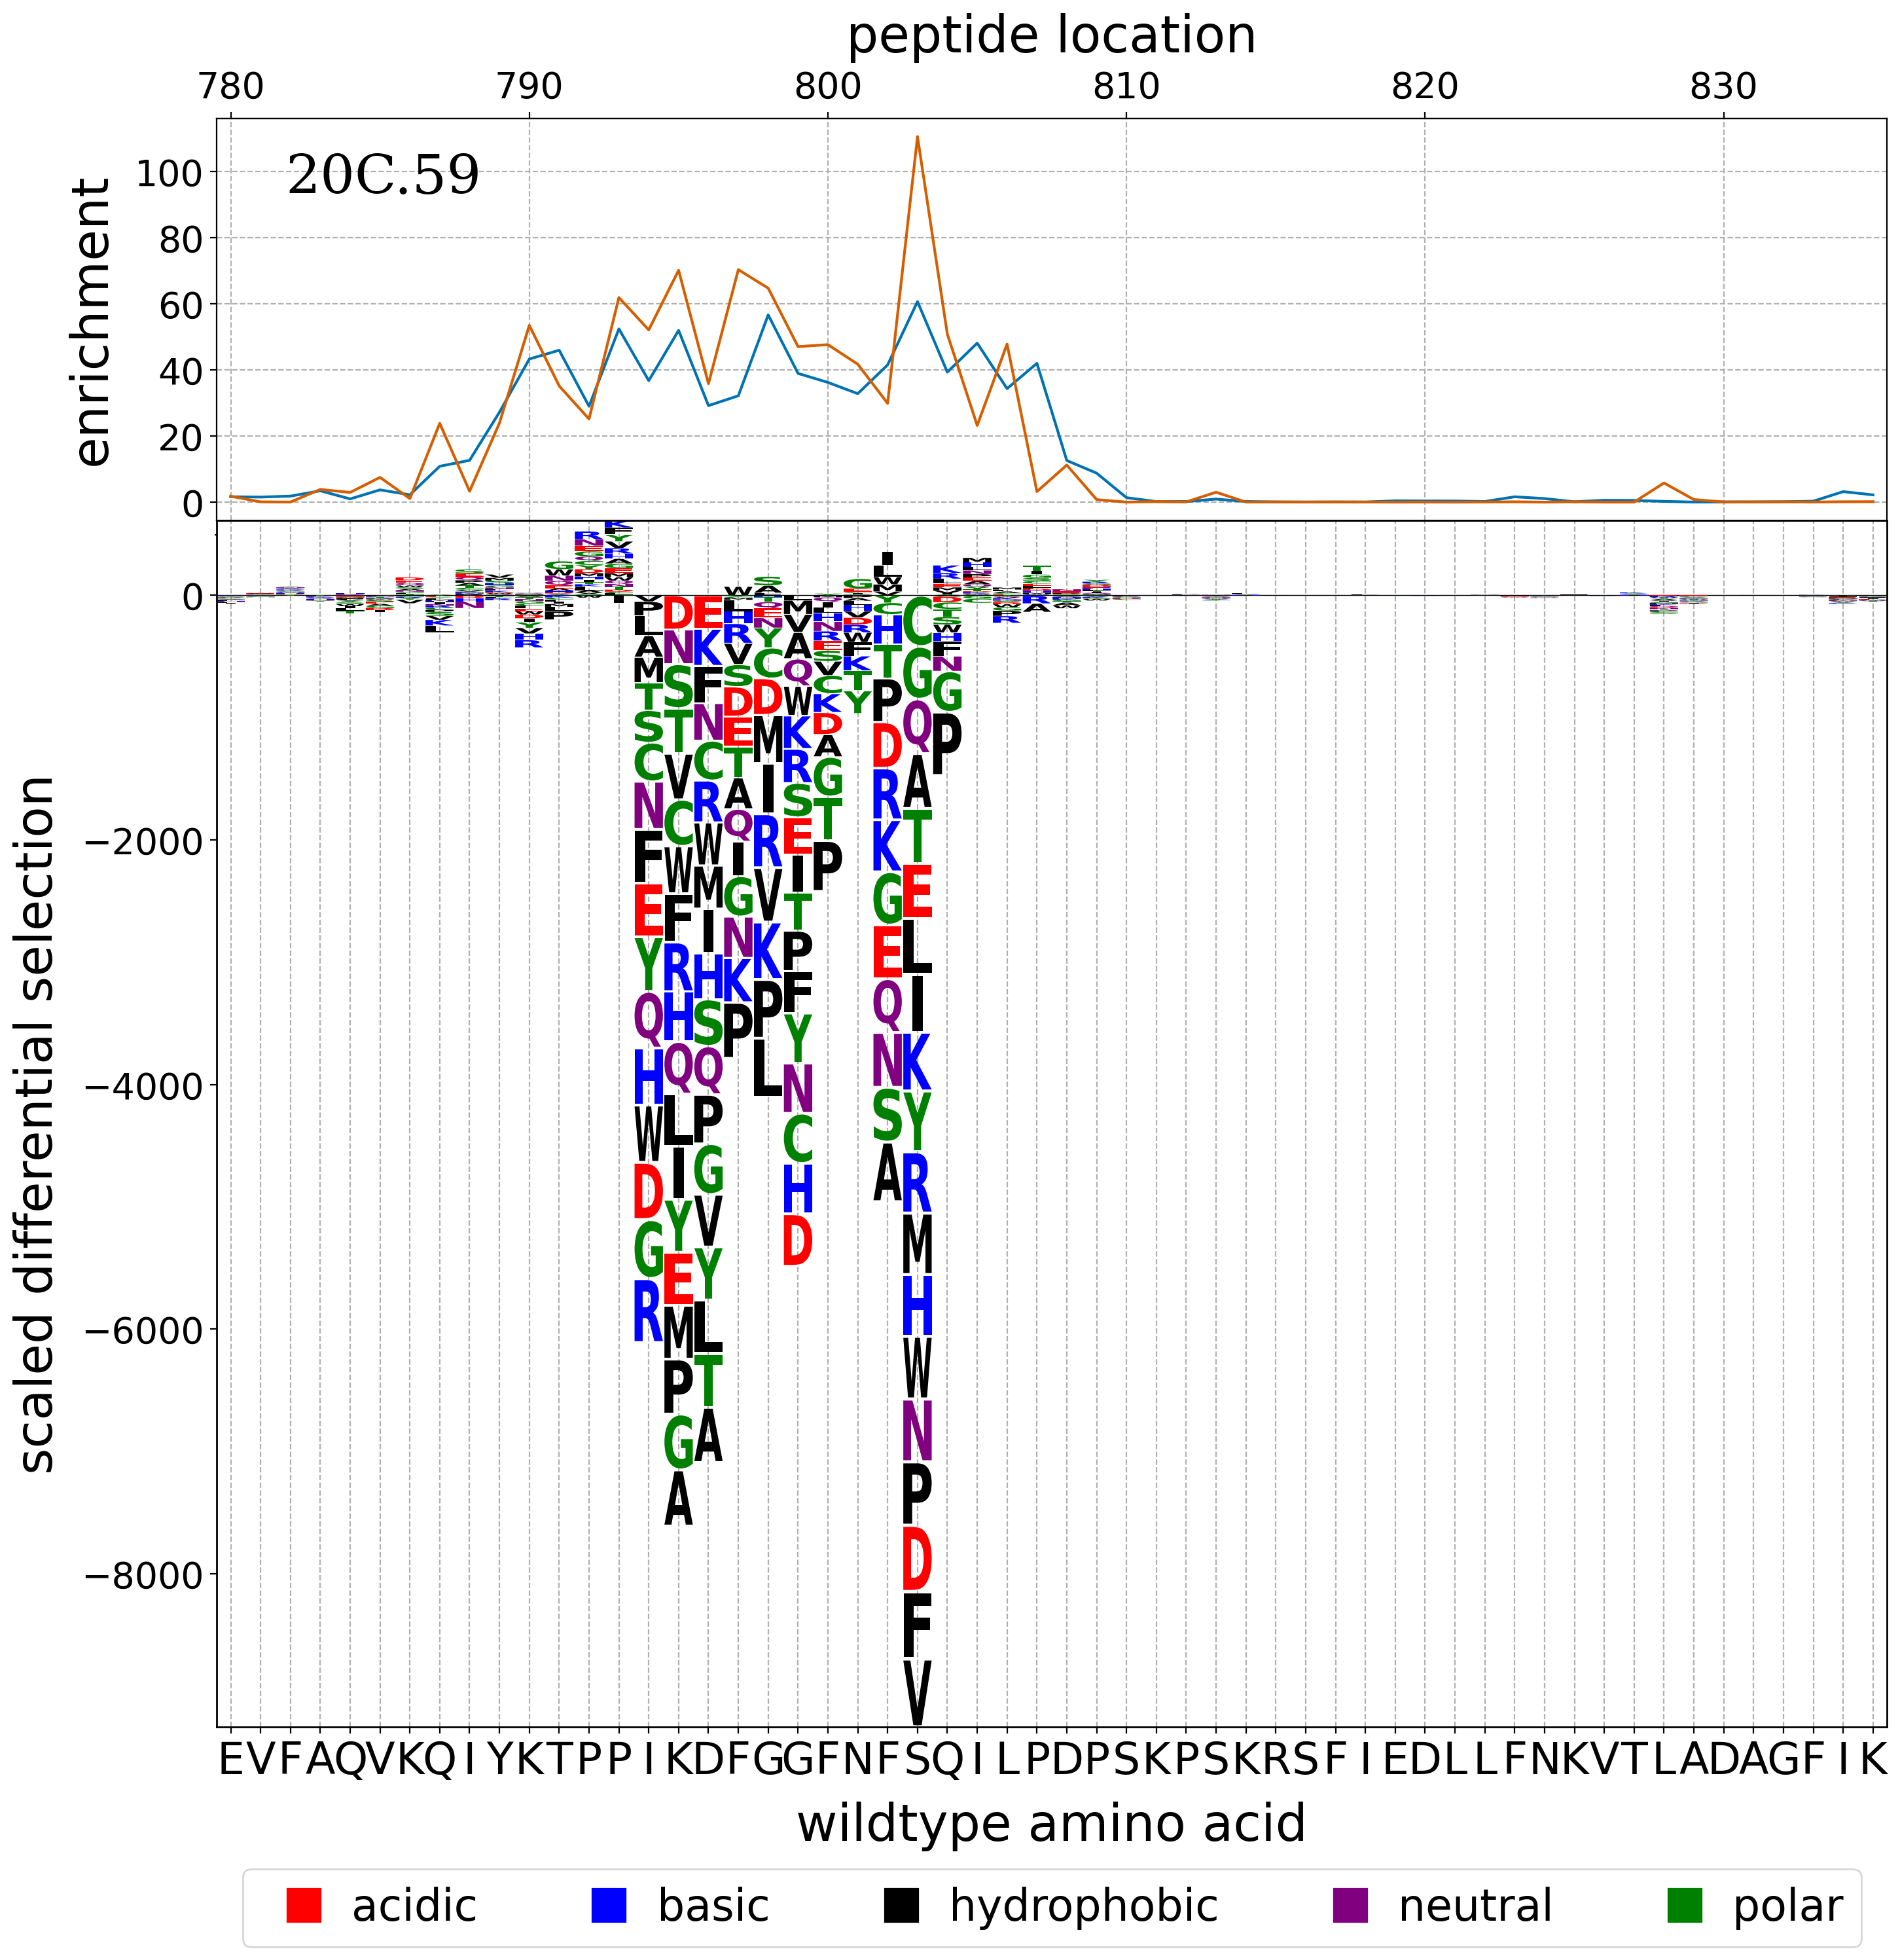

In [5]:
make_plot(mAb_20C_59_ds, loc_start, loc_end, '20C.59', 'mAb_20C_59')

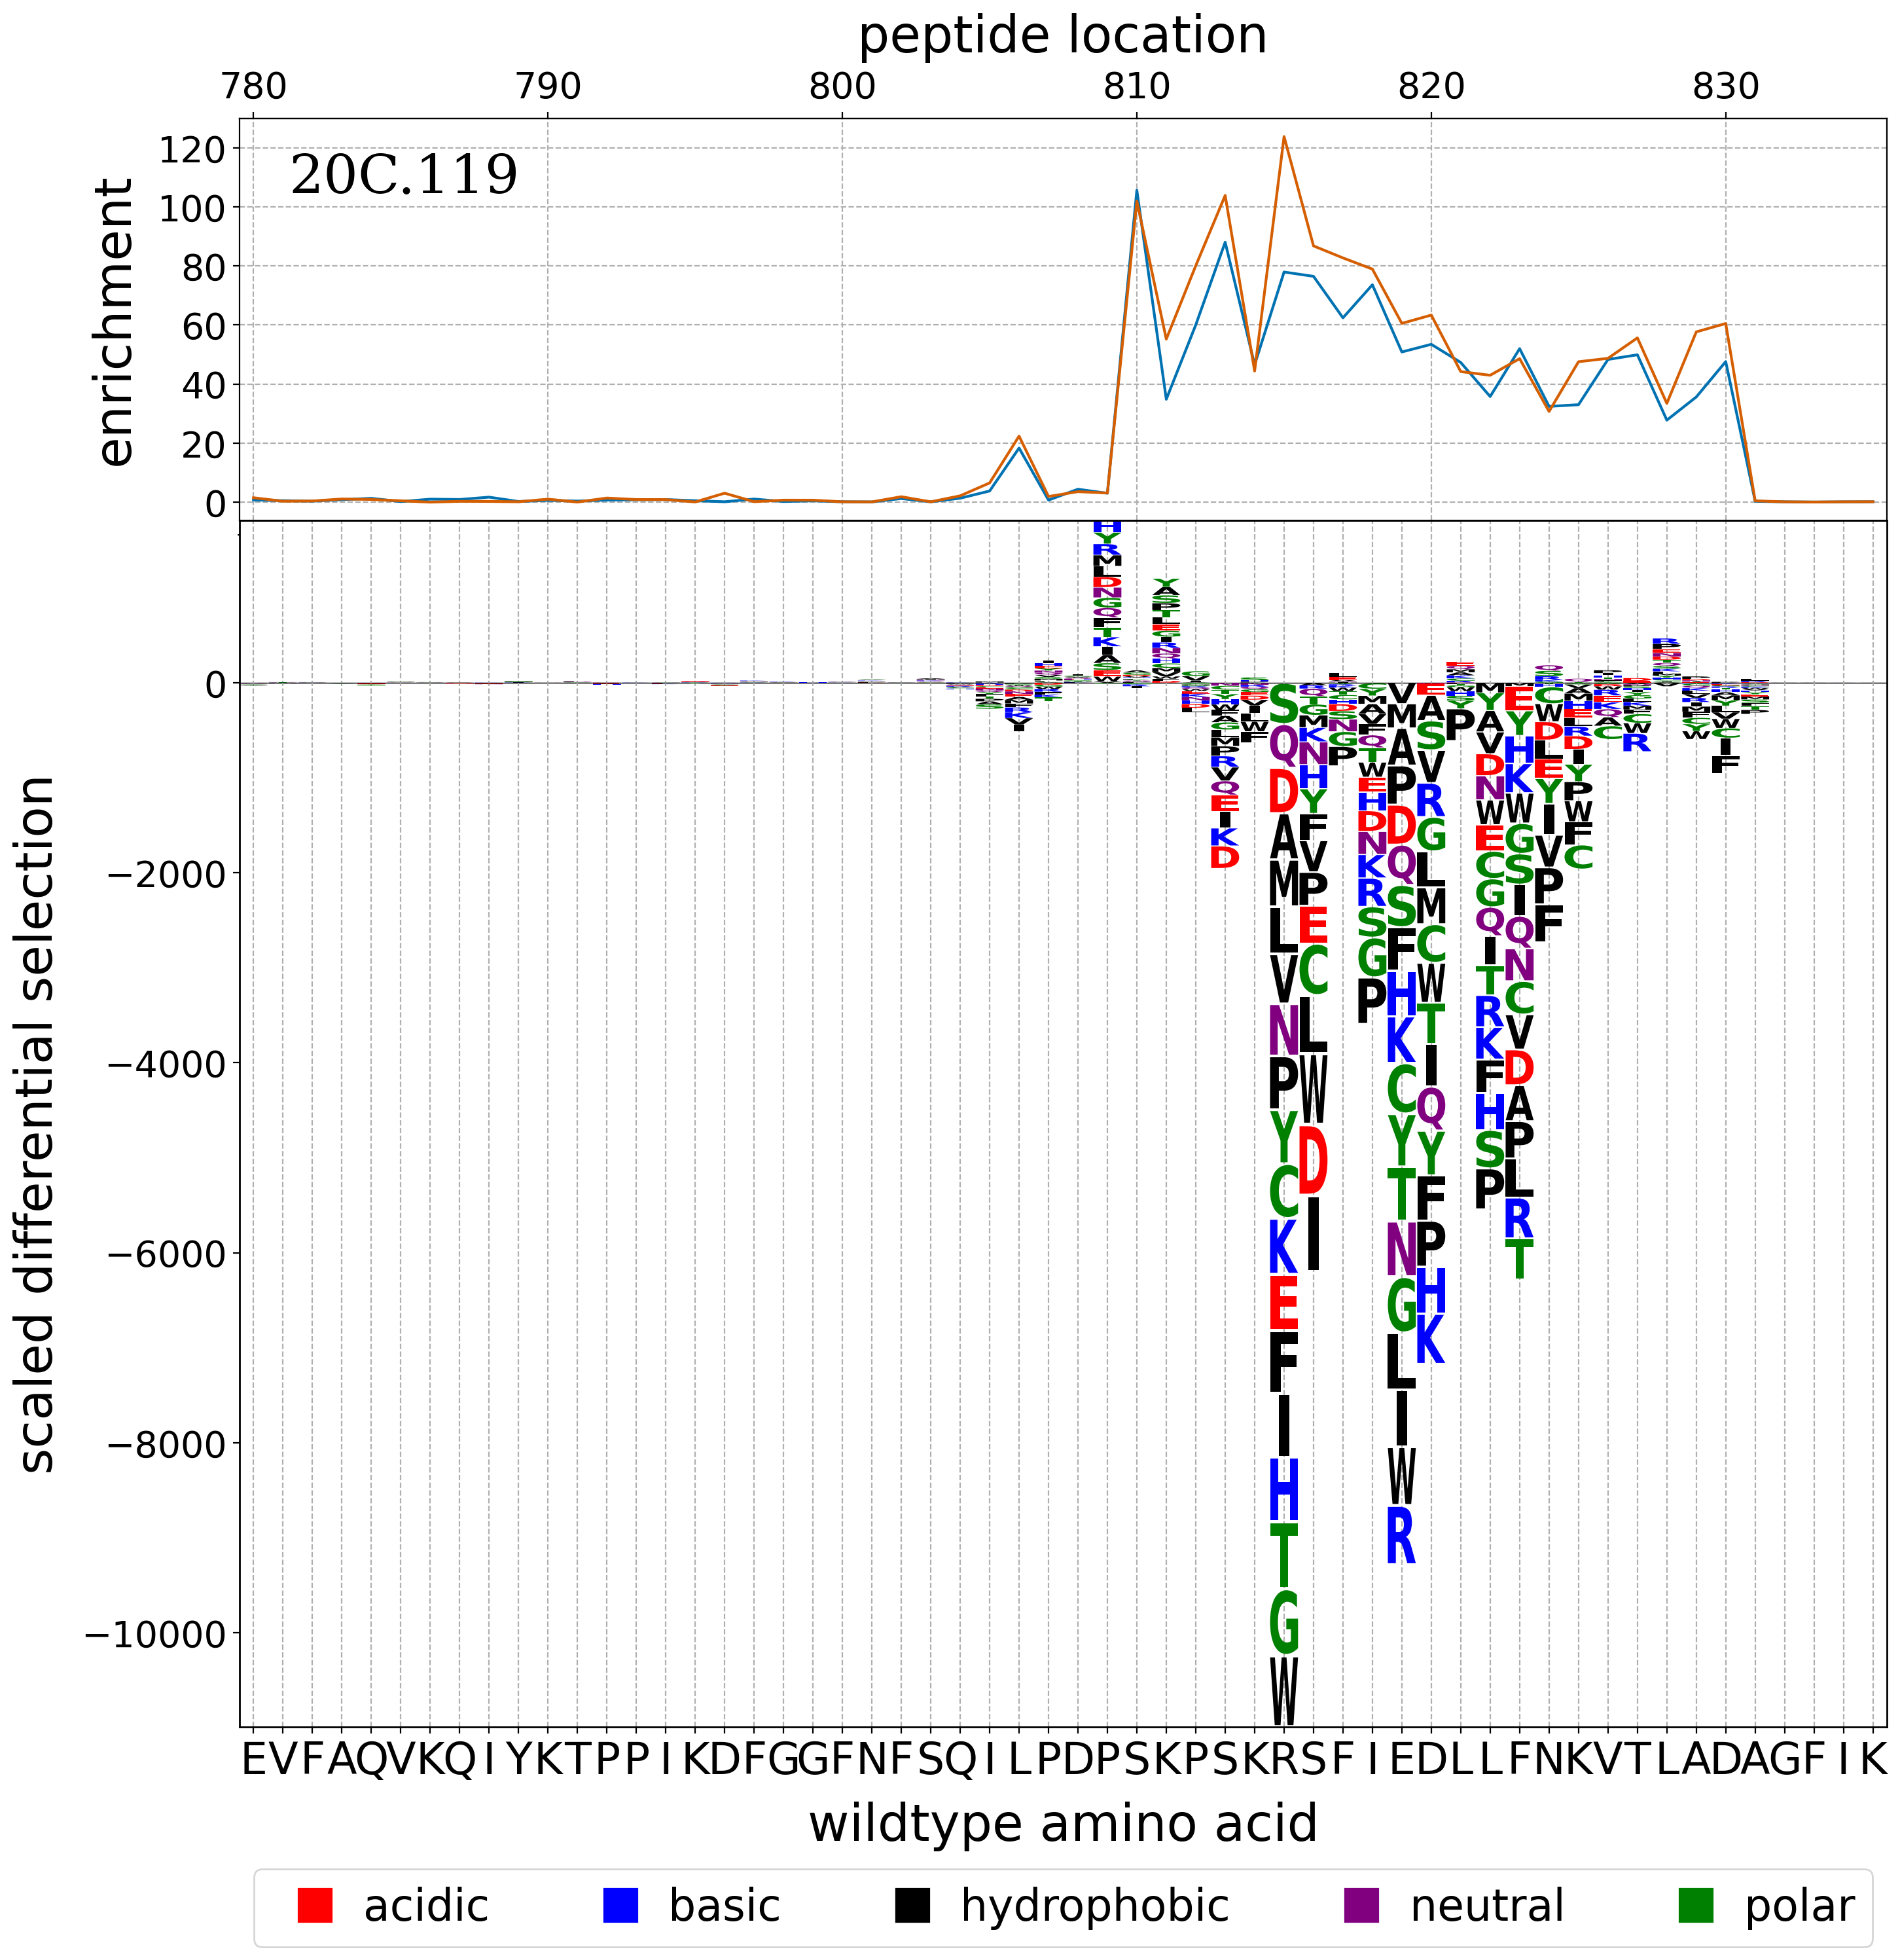

In [6]:
make_plot(mAb_20C_119_ds, loc_start, loc_end, '20C.119', 'mAb_20C_119')